# Example CLOC Simulation
The point here is to show how to set up a minimum, working closed loop, with a very simple threshold-triggered control scheme.

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *
from cleosim import *

import matplotlib.pyplot as plt

# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"

## Set up network

In [2]:
n = 10
population = NeuronGroup(n, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(n, np.linspace(0, 100, n)*Hz + 10*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition='abs(i-j)<=3')

pop_mon = SpikeMonitor(population)
state_mon = StateMonitor(population, 'v', range(n))

net = Network([population, input_group,S, pop_mon, state_mon])

print("Recorded population's equations:")
population.user_equations

Recorded population's equations:


dv/dt = (I*Rm - 70*mV - v)/tau : volt
tau : second
Rm : ohm
I : amp


## Run simulation

In [3]:
net.run(200*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.05s). [brian2.stateupdaters.base.method_choice]


We shouldn't see the activity in the recorded group affect the controlled group, since
the IO processor isn't set up yet. 

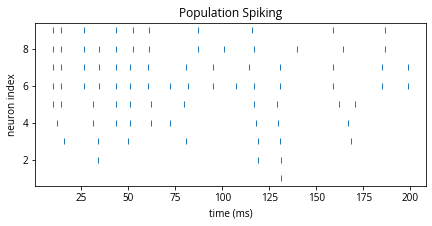

In [4]:
fig_size=(7, 3)
plt.figure(figsize=fig_size);
plt.plot(pop_mon.t / ms, pop_mon.i, '|'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');
plt.show();

## IO processor setup
Now we'll set up the IO processor and should see activity in the controlled neuron (index 0).
We'll use a simplistic setup where the recorder simply reports the voltage of a given neuron (of index 5 in our case), the controller outputs a pulse whenever
that voltage is below a certain threshold,
and the stimulator applies that pulse to the specified neurons. So if everything is
wired correctly, we'll see bursts of activity in the first 10 neurons.

In [5]:
from cleosim.recorders import RateRecorder, VoltageRecorder
from cleosim.stimulators import StateVariableSetter
from cleosim import *  # for reloading

i_rec = int(n/2)
i_ctrl = 0
sim = CLSimulator(net)
v_rec = VoltageRecorder('rec')
sim.inject_recorder(v_rec, population[i_rec])
sim.inject_stimulator(
        StateVariableSetter(
            'stim', variable_to_ctrl='I', unit=nA),
        population[i_ctrl]
)

We need to implement the `LatencyIOProcessor` object. For a more sophisticated case we'd use `ProcessingBlock` objects to decompose 
the computation in the `compute_ctrl_signal` function.

In [6]:
from cleosim.processing import LatencyIOProcessor
trigger_threshold = -60*mV

class ReactivePulseIOProcessor(LatencyIOProcessor):
    def __init__(self, pulse_current=1):
        super().__init__(sampling_period_ms=1)
        self.pulse_current = pulse_current
        self.out = {}

    def compute_ctrl_signal(self, state_dict, time_ms):
        v = state_dict['rec']
        if v is not None and v < trigger_threshold:
            self.out['stim'] = self.pulse_current
        else:
            self.out['stim'] = 0

        return (self.out, time_ms)

sim.set_io_processor(ReactivePulseIOProcessor(1))

And run the simulation:

In [7]:
sim.run(200*ms)

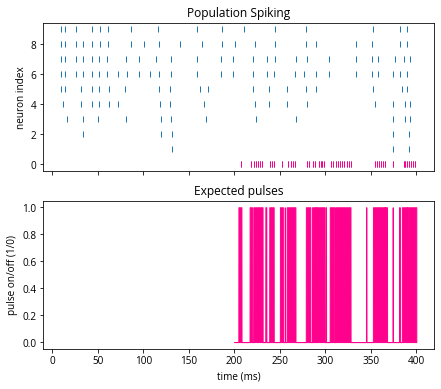

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 6));
ax1.plot(pop_mon.t / ms, pop_mon.i, '|'); 
ax1.plot(pop_mon.t[pop_mon.i == i_ctrl] / ms, pop_mon.i[pop_mon.i == i_ctrl], '|', c='xkcd:hot pink'); 
ax1.set_title('Population Spiking'); ax1.set_ylabel('neuron index'); plt.xlabel('time (ms)');
ax2.fill_between(v_rec.mon.t / ms, (v_rec.mon.v.T < trigger_threshold)[:, 0], color='xkcd:hot pink');
plt.title('Expected pulses'); plt.xlabel('time (ms)'); plt.ylabel('pulse on/off (1/0)');


Yes, we see the IO processor triggering pulses as expected.
And here's a plot of neuron 50's voltage to confirm that those pulses
are indeed where we expect them to be, whenever the voltage is
below -60 mV.

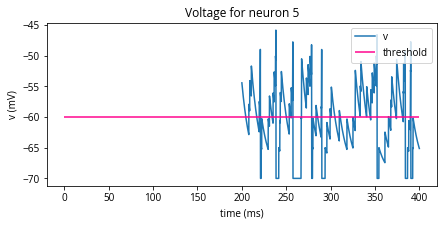

In [9]:
fig, ax = plt.subplots(figsize=fig_size);
ax.set(title=f"Voltage for neuron {i_rec}", ylabel="v (mV)", xlabel='time (ms)')
ax.plot(v_rec.mon.t/ms, v_rec.mon.v.T / mV);
ax.hlines(-60, 0, 400, color='xkcd:hot pink');
ax.legend(['v', 'threshold'], loc='upper right');